In [ ]:
# install
!pip install --quiet --upgrade accelerate diffusers transformers ftfy fastai

# Setup and imports

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
import torch
import numpy as np
import requests
import scipy
import cv2

from transformers import CLIPTextModel, CLIPTokenizer, CLIPFeatureExtractor
from transformers import logging
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from diffusers import (
    AutoencoderKL, 
    UNet2DConditionModel, 
    LMSDiscreteScheduler, 
    StableDiffusionInpaintPipeline
)

from tqdm.auto import tqdm
from torch import autocast
from PIL import Image
from matplotlib import pyplot as plt
from torchvision import transforms as tfms
from io import BytesIO
from scipy import signal
from fastai.basics import show_image, show_images

# for video display
from IPython.display import HTML
from base64 import b64encode

# suppress warning from importing CLIPTextModel
logging.set_verbosity_error()

# set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the models from hugging face

In [ ]:
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
tokenizer = CLIPTokenizer.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="tokenizer")
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")
text_encoder = CLIPTextModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="text_encoder")
scheduler = LMSDiscreteScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")
feature_extractor = CLIPFeatureExtractor.from_pretrained("laion/CLIP-ViT-B-32-laion2B-s34B-b79K", subfolder="feature_extractor")
safety_checker = StableDiffusionSafetyChecker()

# inpaint = StableDiffusionInpaintPipeline.from_pretrained('runwayml/stable-diffusion-inpainting',revision="fp16",torch_dtype=torch.float16).to(torch_device)
inpaint = StableDiffusionInpaintPipline(
    vae=vae,
    text_encoder=text_encoder,
    tokenizer=tokenizer,
    unet=unet,
    scheduler=scheduler,
    safety_checker=safety_checker,
    feature_extractor=feature_extractor,
)

# set model to device
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)
feature_extractor = feature_extractor.to(torch_device)

/usr/local/lib/python3.8/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


TypeError: ignored

# Utilities

In [ ]:
# parameters
height = 512
width = 512
num_inference_steps = 50
base_guidance_scale = 7
generator = torch.Generator(device=torch_device)
generator.manual_seed(1)
batch_size = 1

scheduler.set_timesteps(num_inference_steps)

In [ ]:
def get_pil_image_from_url(url):
    response = requests.get(url)
    return Image.open(BytesIO(response.content))

def pil_to_latents(img):
    img_tensor = tfms.ToTensor()(img).to(torch_device)
    batched_img_tensor = img_tensor.unsqueeze(0)
    renormalised_batched_img_tensor = batched_img_tensor * 2 - 1
    with torch.no_grad():
        latent = vae.encode(renormalised_batched_img_tensor)
    rescaled_latent = 0.18215 * latent.latent_dist.sample()[0]
    return rescaled_latent

def noise_latents(latents, noise_start_step=10):
    noise = torch.randn_like(latents)
    noise_level = torch.tensor([scheduler.timesteps[noise_start_step]])
    noised_latent = scheduler.add_noise(
        latents, noise, timesteps=noise_level
    )
    return noised_latent

def get_initial_latents():
    latents = torch.randn(
        size=(batch_size, unet.in_channels, height // 8, width // 8),
        generator=generator,
        device=torch_device
    )
    latents *= scheduler.init_noise_sigma
    return latents

def latents_to_pil(latents):
    with torch.no_grad():
        rescaled_latents = latents / 0.18215
        batched_img_tensor = vae.decode(rescaled_latents).sample.detach().cpu()
        batched_img_tensor = (batched_img_tensor / 2 + 0.5).clamp(0, 1)
        to_pil_img = tfms.ToPILImage()
        return [to_pil_img(img_tensor) for img_tensor in batched_img_tensor]

def get_text_embeddings(prompts, uncond_prompts=None):
    assert len(prompts) == batch_size, "Batch size must be equal to number of prompts"
    if uncond_prompts is not None:
        assert isinstance(uncond_prompts, list) and len(uncond_prompts) == batch_size, "Batch size must be equal to number of prompts"

    # get text embedding
    max_tokens_length = tokenizer.model_max_length
    prompt_tokens = tokenizer(
        prompts, 
        padding="max_length", 
        max_length=max_tokens_length, 
        truncation=True, 
        return_tensors="pt"
    )
    uncond_tokens = tokenizer(
        ([""] * batch_size) if uncond_prompts is None else uncond_prompts,
        padding="max_length", 
        max_length=max_tokens_length,      
        return_tensors="pt"  
    )

    with torch.no_grad():
        prompt_embeds = text_encoder(prompt_tokens.input_ids.to(torch_device)).last_hidden_state
        uncond_embeds = text_encoder(uncond_tokens.input_ids.to(torch_device)).last_hidden_state
        text_embeds = torch.concat([uncond_embeds, prompt_embeds])
    
    return text_embeds

In [ ]:
def guided_difussion_from_intial_latents_and_text_embeds(
    init_latents,
    text_embeds,
    init_latent_noise_step=0
):
    latents = init_latents

    # iteratively denoise according to noise schedule
    for step, noise_level in enumerate(scheduler.timesteps):
        if step < init_latent_noise_step:
            continue

        # expand latents and text conditions to save a forward pass
        latents_input = torch.concat([latents] * 2)
        # # scale according to noise level
        latents_input = scheduler.scale_model_input(latents_input, noise_level)

        with torch.no_grad():
            noise_pred = unet(latents_input, noise_level, encoder_hidden_states=text_embeds).sample
        
        # perform guidance
        noise_pred_uncond, noise_pred_cond = noise_pred.chunk(2)
        noise_step = (noise_pred_cond - noise_pred_uncond)
        noise_pred = noise_pred_uncond + base_guidance_scale * noise_step

        # step the scheduler
        latents = scheduler.step(noise_pred, noise_level, latents).prev_sample

    return latents, noise_pred

# Test diffusion forward pass

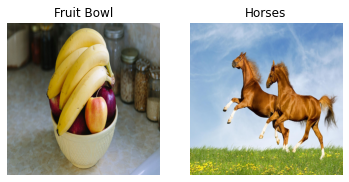

In [ ]:
url = "https://www.hdnicewallpapers.com/Walls/Big/Horse/Two_Beautiful_Brown_Horse_Image.jpg"
img = get_pil_image_from_url(url)
img = img.resize((width, height))

# test on a different image
url = "https://post.healthline.com/wp-content/uploads/2020/04/banana-apple-fruit-bowl-kitchen-1296x728-header.jpg"
fruit_bowl = get_pil_image_from_url(url)
fruit_bowl = fruit_bowl.resize((width, height))

show_images([fruit_bowl, img], titles=["Fruit Bowl", "Horses"])

In [ ]:
with torch.no_grad():
    rescaled_latent = pil_to_latents(img)
    noised_latent = noise_latents(rescaled_latent, noise_start_step=len(scheduler.timesteps) - 1)

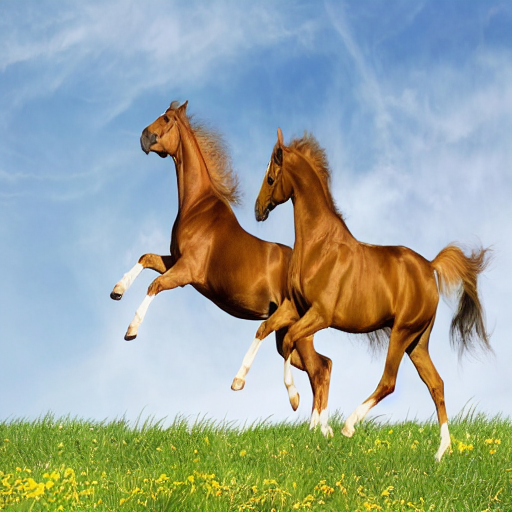

In [ ]:
latents_to_pil(noised_latent.unsqueeze(0))[0]

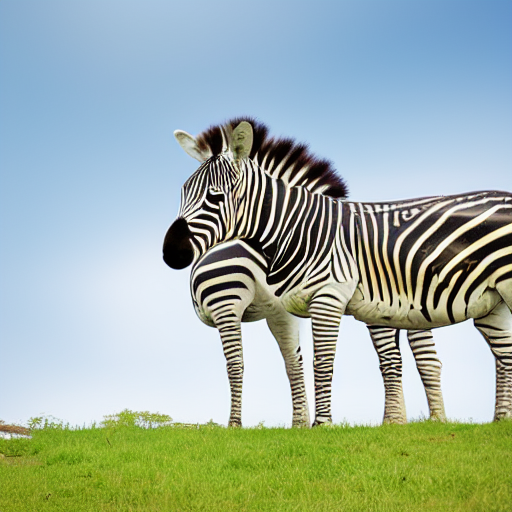

In [ ]:
text_embeds = get_text_embeddings(prompts=["Photograph of two zebras"])

latents_to_pil(guided_difussion_from_intial_latents_and_text_embeds(
    init_latents=noise_latents(rescaled_latent.unsqueeze(0), noise_start_step=10),
    text_embeds=text_embeds,
    init_latent_noise_step=10
)[0])[0]

# Get binary mask diff

## Version 1: full guided diffusion

In [ ]:
scheduler.config

FrozenDict([('num_train_timesteps', 1000),
            ('beta_start', 0.00085),
            ('beta_end', 0.012),
            ('beta_schedule', 'scaled_linear'),
            ('trained_betas', None),
            ('prediction_type', 'epsilon'),
            ('_class_name', 'PNDMScheduler'),
            ('_diffusers_version', '0.7.0.dev0'),
            ('set_alpha_to_one', False),
            ('skip_prk_steps', True),
            ('steps_offset', 1),
            ('clip_sample', False)])

Mask iteration:   0%|          | 0/10 [00:00<?, ?it/s]

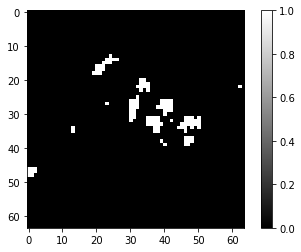

In [ ]:
prompts=["Photograph of two zebras"]
uncond_prompts=["Photograph of two horses"]

# hyper params
num_noise_for_mask = 10 
noise_start_step_multiplier = 0.5

with torch.no_grad():

    noise_start_step = int(noise_start_step_multiplier * len(scheduler.timesteps)) + 1
    rescaled_latent = pil_to_latents(img)
    noised_latent = noise_latents(
        rescaled_latent.unsqueeze(0), 
        noise_start_step=noise_start_step
    )
    
    diff_latents = []
    for _ in tqdm(range(num_noise_for_mask), desc="Mask iteration"):

        horse_latents, horse_noise_pred = guided_difussion_from_intial_latents_and_text_embeds(
            init_latents=noised_latent,
            text_embeds=get_text_embeddings(uncond_prompts),
            init_latent_noise_step=noise_start_step,
        )

        zebra_latents, zebra_noise_pred = guided_difussion_from_intial_latents_and_text_embeds(
            init_latents=noised_latent,
            text_embeds=get_text_embeddings(prompts),
            init_latent_noise_step=noise_start_step,
        )

        diff_latents.append(horse_noise_pred - zebra_noise_pred)
    
    diff_latents = torch.cat(diff_latents)
    diff_agg = diff_latents.abs().mean(dim=(0, 1)).cpu().numpy()
    # convole
    kernel = 1/9 * np.ones((3, 3))
    diff_agg = torch.Tensor(signal.convolve2d(diff_agg, kernel, mode='same')).to(torch_device)
    # 0 - 1 scaling
    diff_agg = (diff_agg - diff_agg.min()) / (diff_agg.max() - diff_agg.min())
    

cbar = plt.imshow((diff_agg > 0.35).cpu().numpy(), cmap='gray')
plt.colorbar(cbar)
plt.show()

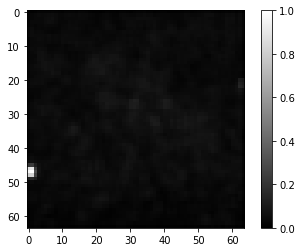

In [ ]:
diff_agg = diff_latents.pow(2).sum(dim=1).pow(0.5).amax(dim=0).cpu().numpy()
# convole
kernel = 1/9 * np.ones((3, 3))
diff_agg = torch.Tensor(signal.convolve2d(diff_agg, kernel, mode='same')).to(torch_device)
# 0 - 1 scaling
diff_agg = (diff_agg - diff_agg.min()) / (diff_agg.max() - diff_agg.min())

cbar = plt.imshow(diff_agg.cpu().numpy(), cmap='gray')
plt.colorbar(cbar)
plt.show()

Mask iteration:   0%|          | 0/10 [00:00<?, ?it/s]

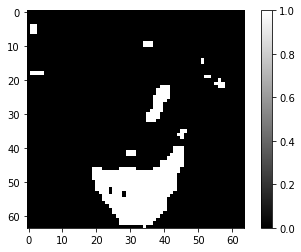

In [ ]:
# test on a different image
url = "https://post.healthline.com/wp-content/uploads/2020/04/banana-apple-fruit-bowl-kitchen-1296x728-header.jpg"
fruit_bowl = get_pil_image_from_url(url)
fruit_bowl = fruit_bowl.resize((width, height))

prompts = ["Photograph of a brown, woven basket of fruits"]
uncond_prompts = ["Photograph of a white porcelain bowl of fruits"]

# hyper params
num_noise_for_mask = 10 
noise_start_step_multiplier = 0.5

with torch.no_grad():
    noise_start_step = int(noise_start_step_multiplier * len(scheduler.timesteps))
    rescaled_latent = pil_to_latents(fruit_bowl)
    noised_latent = noise_latents(
        rescaled_latent.unsqueeze(0), 
        noise_start_step=noise_start_step
    )
    
    diff_latents = []
    for _ in tqdm(range(num_noise_for_mask), desc="Mask iteration"):

        fruit_bowl_latents = guided_difussion_from_intial_latents_and_text_embeds(
            init_latents=noised_latent,
            text_embeds=get_text_embeddings(uncond_prompts),
            init_latent_noise_step=noise_start_step,
        )

        basket_latents = guided_difussion_from_intial_latents_and_text_embeds(
            init_latents=noised_latent,
            text_embeds=get_text_embeddings(prompts),
            init_latent_noise_step=noise_start_step,
        )

        diff_latents.append(fruit_bowl_latents - basket_latents)
    
    diff_latents = torch.cat(diff_latents)
    diff_agg = diff_latents.abs().mean(dim=(0, 1)).cpu().numpy()
    # convole
    kernel = 1/9 * np.ones((3, 3))
    diff_agg = torch.Tensor(signal.convolve2d(diff_agg, kernel, mode='same')).to(torch_device)
    # 0 - 1 scaling
    diff_agg = (diff_agg - diff_agg.min()) / (diff_agg.max() - diff_agg.min())

cbar = plt.imshow((diff_agg > 0.35).cpu().numpy(), cmap='gray')
plt.colorbar(cbar)
plt.show()

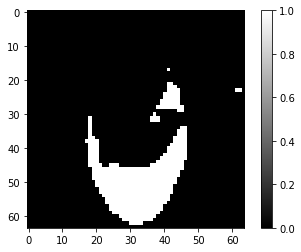

In [ ]:
diff_agg = diff_latents.abs().mean(dim=(0, 1)).cpu().numpy()
# convole
kernel = 1/9 * np.ones((3, 3))
diff_agg = torch.Tensor(signal.convolve2d(diff_agg, kernel, mode='same')).to(torch_device)
# 0 - 1 scaling
diff_agg = (diff_agg - diff_agg.min()) / (diff_agg.max() - diff_agg.min())

cbar = plt.imshow((diff_agg>0.35).cpu().numpy(), cmap='gray')
plt.colorbar(cbar)
plt.show()

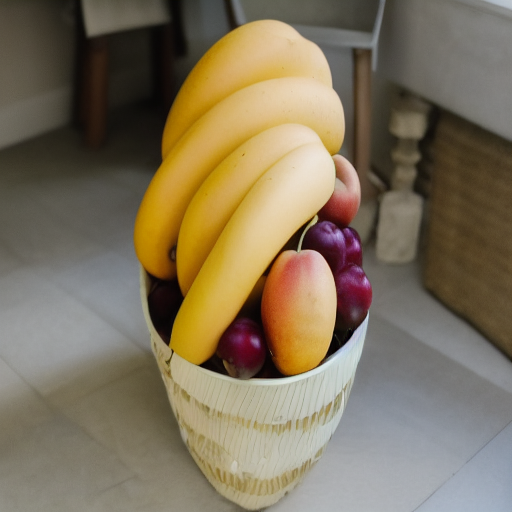

In [ ]:
# sanity check
latents_to_pil(basket_latents)[0]

## Version 2: single noise-step

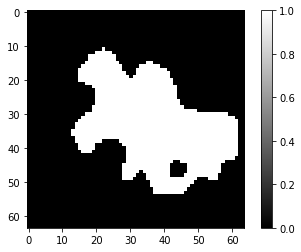

In [ ]:
prompts=["Photograph of two zebras"]
uncond_prompts=["Photograph of two horses"]

# hyper params
num_noise_for_mask = 10 
noise_start_step_multiplier = 0.5

with torch.no_grad():
    rescaled_latent = pil_to_latents(img)
    text_embeds = get_text_embeddings(prompts, uncond_prompts=uncond_prompts)
    noise_start_step = int(noise_start_step_multiplier * len(scheduler.timesteps))
    diff_latents = []

    for i in range(num_noise_for_mask):

        noise = torch.randn_like(rescaled_latent).to(torch_device)
        noise_level = torch.tensor([scheduler.timesteps[noise_start_step]]).to(torch_device)
        noised_latent = scheduler.add_noise(
            rescaled_latent, noise, timesteps=noise_level
        )
        noised_latent = scheduler.scale_model_input(noised_latent, noise_level)
        # batch-ify noised_latent
        if len(noised_latent.shape) == 3:
            noised_latent = noised_latent.unsqueeze(0)
        latents_input = torch.concat([noised_latent] * 2)

        noise_pred = unet(latents_input, noise_level, encoder_hidden_states=text_embeds).sample
        noise_pred_uncond, noise_pred_cond = noise_pred.chunk(2)

        noise_diff = noise_pred_uncond - noise_pred_cond
        diff_latents.append(noise_diff)
    
    diff_latents = torch.cat(diff_latents)
    diff_agg = diff_latents.abs().pow(2).sum(dim=1).pow(0.5).mean(dim=0).cpu().numpy()
    
    # convole
    kernel = 1/9 * np.ones((5, 5))
    diff_agg = signal.convolve2d(diff_agg, kernel, mode='same')
    # diff_agg = cv2.GaussianBlur(diff_agg, (5,5), 1)

    diff_agg_norm = (diff_agg - diff_agg.min()) / (diff_agg.max() - diff_agg.min())

cbar = plt.imshow(diff_agg_norm > 0.35, cmap='gray')
plt.colorbar(cbar)
plt.show()

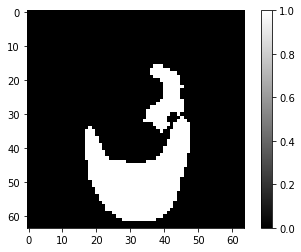

In [ ]:
prompts = ["Photograph of a basket of fruits"]
uncond_prompts = ["Photograph of a bowl of fruits"]

# hyper params
num_noise_for_mask = 10 
noise_start_step_multiplier = 0.5

with torch.no_grad():
    rescaled_latent = pil_to_latents(fruit_bowl)
    text_embeds = get_text_embeddings(prompts, uncond_prompts=uncond_prompts)
    noise_start_step = int(noise_start_step_multiplier * len(scheduler.timesteps))
    diff_latents = []

    for i in range(num_noise_for_mask):

        noise = torch.randn_like(rescaled_latent).to(torch_device)
        noise_level = torch.tensor([scheduler.timesteps[noise_start_step]]).to(torch_device)
        noised_latent = scheduler.add_noise(
            rescaled_latent, noise, timesteps=noise_level
        )
        noised_latent = scheduler.scale_model_input(noised_latent, noise_level)
        # batch-ify noised_latent
        if len(noised_latent.shape) == 3:
            noised_latent = noised_latent.unsqueeze(0)
        latents_input = torch.concat([noised_latent] * 2)

        noise_pred = unet(latents_input, noise_level, encoder_hidden_states=text_embeds).sample
        noise_pred_uncond, noise_pred_cond = noise_pred.chunk(2)

        noise_diff = noise_pred_uncond - noise_pred_cond
        diff_latents.append(noise_diff)
    
    diff_latents = torch.cat(diff_latents)
    diff_agg = diff_latents.abs().pow(2).sum(dim=1).pow(0.5).mean(dim=0).cpu().numpy()
    
    # convole
    kernel = 1/9 * np.ones((5, 5))
    diff_agg = signal.convolve2d(diff_agg, kernel, mode='same')
    # diff_agg = cv2.GaussianBlur(diff_agg, (5,5), 1)

    diff_agg_norm = (diff_agg - diff_agg.min()) / (diff_agg.max() - diff_agg.min())

cbar = plt.imshow(diff_agg_norm > 0.35, cmap='gray')
plt.colorbar(cbar)
plt.show()

## Function wrapper

In [ ]:
def make_binary_mask_for_latent_with_target_and_uncond_prompts(
    unnoised_latent,
    prompts,
    uncond_prompts
):
    num_noise_for_mask = 10 
    noise_start_step_multiplier = 0.5

    with torch.no_grad():
        text_embeds = get_text_embeddings(prompts, uncond_prompts=uncond_prompts)
        noise_start_step = int(noise_start_step_multiplier * len(scheduler.timesteps))
        diff_latents = []

        for i in range(num_noise_for_mask):

            noise = torch.randn_like(unnoised_latent).to(torch_device)
            noise_level = torch.tensor([scheduler.timesteps[noise_start_step]]).to(torch_device)
            noised_latent = scheduler.add_noise(
                unnoised_latent, noise, timesteps=noise_level
            )
            noised_latent = scheduler.scale_model_input(noised_latent, noise_level)
            # batch-ify noised_latent
            if len(noised_latent.shape) == 3:
                noised_latent = noised_latent.unsqueeze(0)
            latents_input = torch.concat([noised_latent] * 2)

            noise_pred = unet(latents_input, noise_level, encoder_hidden_states=text_embeds).sample
            noise_pred_uncond, noise_pred_cond = noise_pred.chunk(2)

            noise_diff = noise_pred_uncond - noise_pred_cond
            diff_latents.append(noise_diff)
        
        diff_latents = torch.cat(diff_latents)
        diff_agg = diff_latents.abs().pow(2).sum(dim=1).pow(0.5).mean(dim=0).cpu().numpy()
        
        # convole
        kernel = 1/9 * np.ones((5, 5))
        diff_agg = signal.convolve2d(diff_agg, kernel, mode='same')
        # diff_agg = cv2.GaussianBlur(diff_agg, (5,5), 1)

        diff_agg_norm = (diff_agg - diff_agg.min()) / (diff_agg.max() - diff_agg.min())
    
    return diff_agg_norm > 0.35

# Apply mask on sampling step

In [ ]:
def edit_from_prompt_and_intial_image_with_mask(
    prompts, 
    img,
    uncond_prompts=None
):
    img_latents_orig = pil_to_latents(img)
    latents = torch.randn(
        size=(batch_size, unet.in_channels, height // 8, width // 8),
        generator=generator,
        device=torch_device
    )
    latents *= scheduler.init_noise_sigma
    text_embeds = get_text_embeddings(prompts, uncond_prompts=uncond_prompts)

    # get binary mask
    latent_bin_mask = torch.Tensor(
        make_binary_mask_for_latent_with_target_and_uncond_prompts(
            img_latents_orig,
            prompts,
            uncond_prompts
        )
    ).to(torch_device).to(torch.bool)


    # iteratively denoise according to noise schedule
    for step, noise_level in enumerate(scheduler.timesteps):

        # expand latents and text conditions to save a forward pass
        latents_input = torch.concat([latents] * 2)
        latents_input = scheduler.scale_model_input(latents_input, noise_level)

        with torch.no_grad():
            noise_pred = unet(latents_input, noise_level, encoder_hidden_states=text_embeds).sample
        
        # perform guidance
        noise_pred_uncond, noise_pred_cond = noise_pred.chunk(2)
        noise_step = (noise_pred_cond - noise_pred_uncond)
        noise_pred = noise_pred_uncond + base_guidance_scale * noise_step

        # step the scheduler
        latents = scheduler.step(noise_pred, noise_level, latents).prev_sample

        # apply the mask
        noised_img_latents = noise_latents(img_latents_orig, noise_start_step=step)
        latents = latents * (latent_bin_mask) + noised_img_latents * (~latent_bin_mask)

    return latents

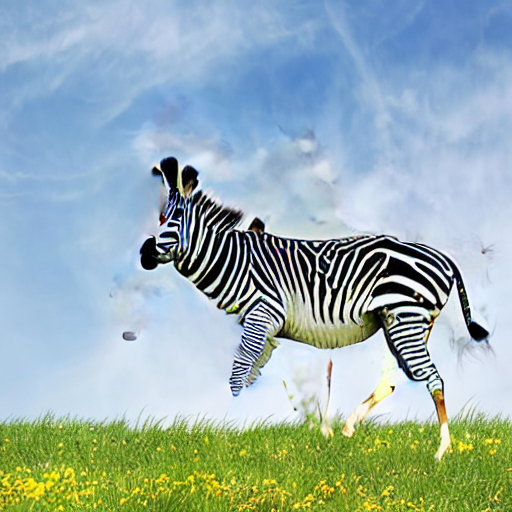

In [ ]:
latents_to_pil(edit_from_prompt_and_intial_image_with_mask(
    prompts=["Photograph of two zebras"],
    uncond_prompts=["Photograph of two horses"],
    img=img
))[0]

# Test with inpainting pipe

  0%|          | 0/50 [00:00<?, ?it/s]

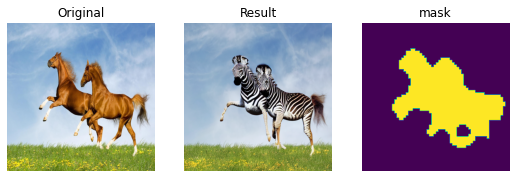

In [ ]:
img = get_pil_image_from_url("https://www.hdnicewallpapers.com/Walls/Big/Horse/Two_Beautiful_Brown_Horse_Image.jpg").resize((width, height))
mask = Image.fromarray(
    make_binary_mask_for_latent_with_target_and_uncond_prompts(
        unnoised_latent=pil_to_latents(img),
        prompts=['Photograph of two horses'],
        uncond_prompts=['Photograph of two zebras']
    )
).resize((width, height))

im_result = inpaint(
    prompt=['Photograph of two zebras'],
    image=img,
    mask_image=mask,
    generator=generator
).images[0] 

show_images([img, im_result, mask], titles=['Original','Result', 'mask'])